### Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import warnings
warnings.filterwarnings('ignore')

### Loading and Formatting data

In [5]:
electricity_data = pd.read_csv("Historic_Demand.csv")
electricity_data.head()
electricity_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   DATE                          561 non-null    object 
 1   Electricty_Consumption_in_TW  561 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.9+ KB


### Time Series Transformation

In [6]:
electricity_data['DATE'] = pd.to_datetime(electricity_data.DATE, format='%m/%d/%Y')
electricity_data.set_index(electricity_data.DATE, inplace=True)
electricity_data.info()

# Creating month and year columns for exploratory data analysis (EDA)
electricity_data['Month'] = electricity_data.DATE.dt.month
electricity_data['Year'] = electricity_data.DATE.dt.year

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 561 entries, 1973-01-01 to 2019-09-01
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   DATE                          561 non-null    datetime64[ns]
 1   Electricty_Consumption_in_TW  561 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 13.1 KB


### Exploratory Data Analysis (EDA)

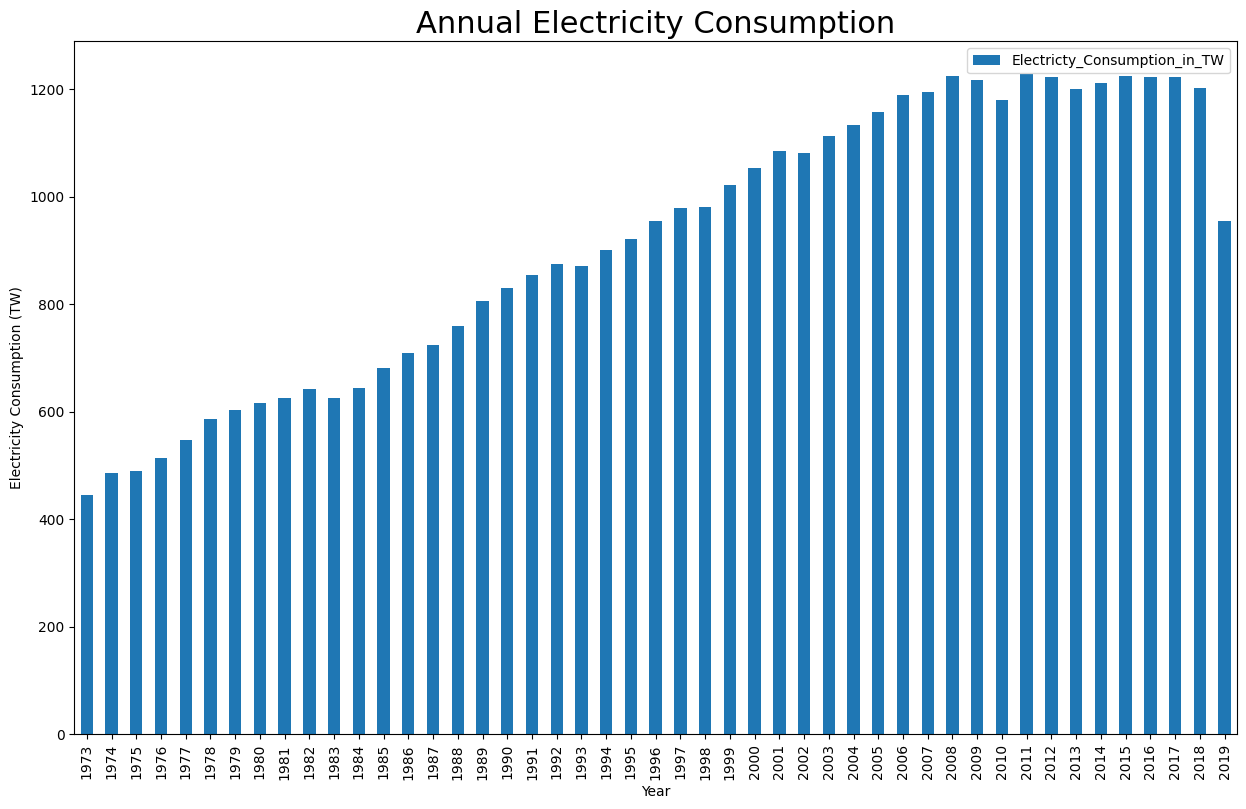

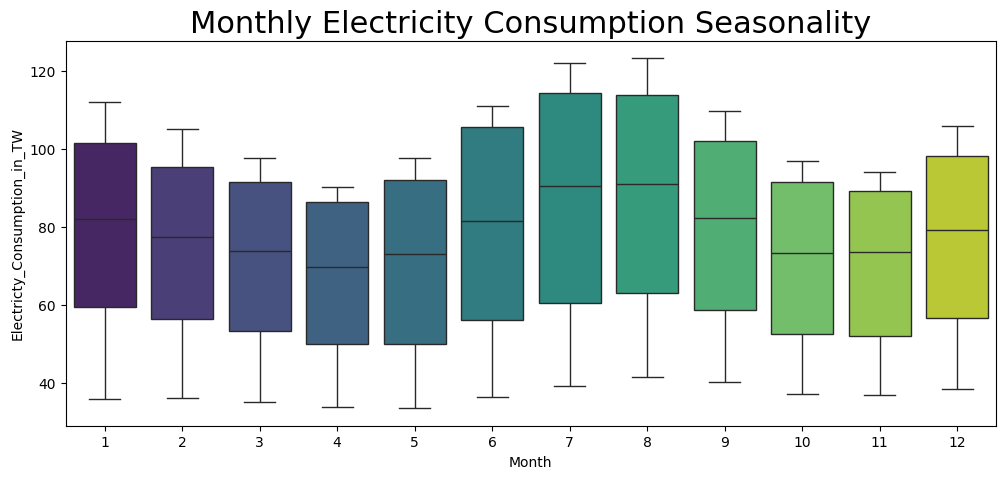

In [8]:
electricity_data.groupby('Year')[['Electricty_Consumption_in_TW']].sum().plot(kind='bar', figsize=(15,9))
plt.title('Annual Electricity Consumption', fontsize=22)
plt.ylabel('Electricity Consumption (TW)')
plt.show()

monthly_trend = electricity_data.groupby('Month')[['Electricty_Consumption_in_TW']].sum()
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(x='Month', y='Electricty_Consumption_in_TW', data=electricity_data, palette='viridis')
plt.title('Monthly Electricity Consumption Seasonality', fontsize=22)
plt.show()

### Checking for Missing Values

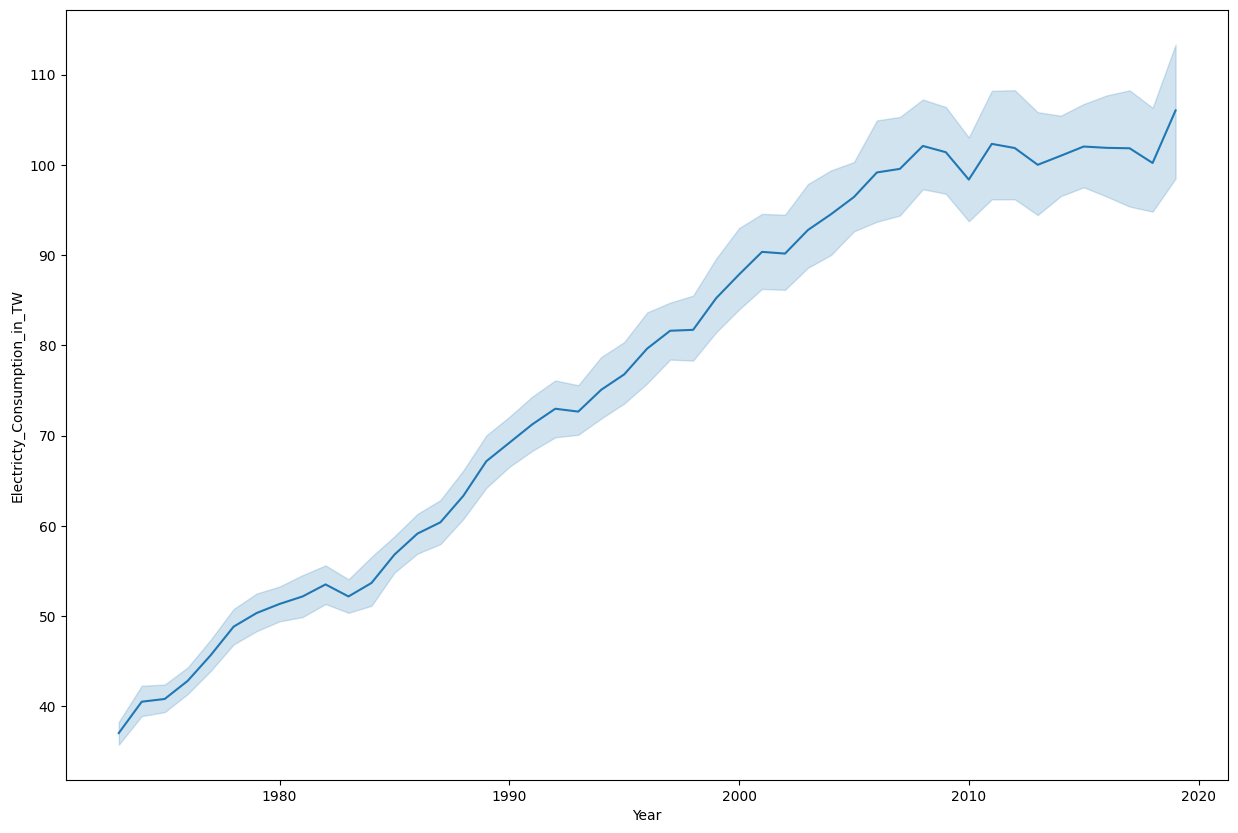

In [9]:
pd.pivot_table(index='Year', columns='Month', values='Electricty_Consumption_in_TW', data=electricity_data)
plt.figure(figsize=(15,10))
sns.lineplot(x=electricity_data.Year, y=electricity_data.Electricty_Consumption_in_TW)
plt.show()

### Time Series Analysis :

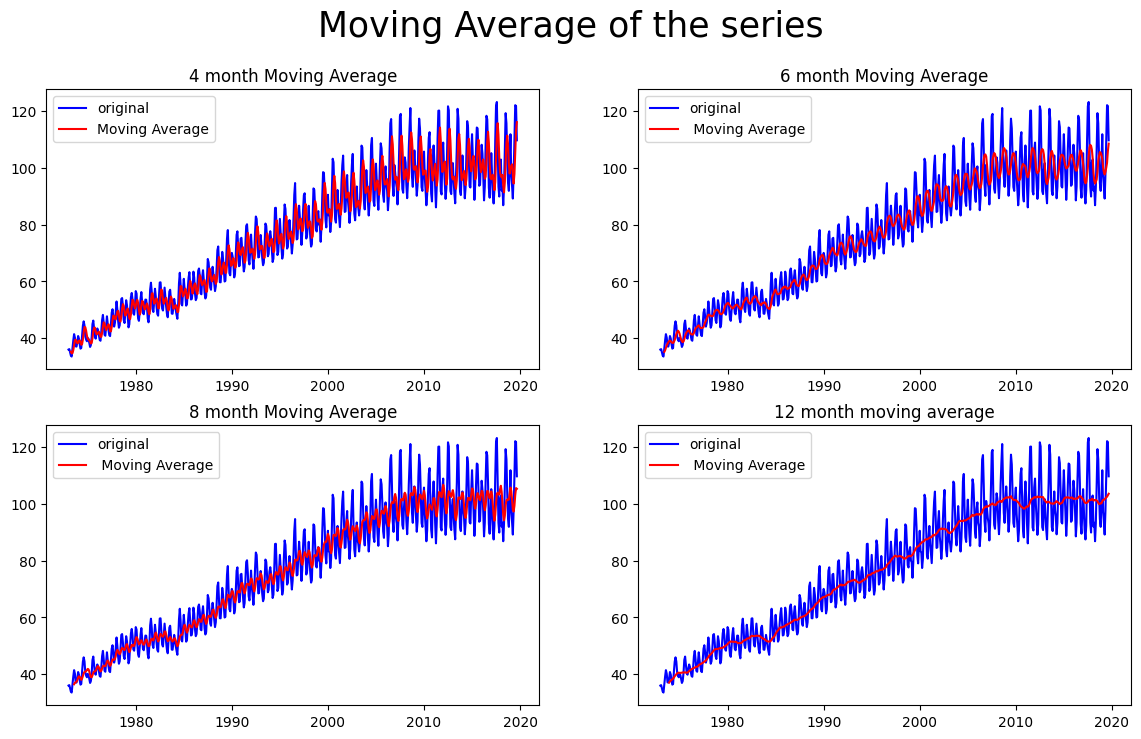

In [10]:
time_series = electricity_data.Electricty_Consumption_in_TW

# Rolling average of series
fig,axes = plt.subplots(2,2,sharex=False,sharey=False)
fig.set_figwidth(14)
fig.set_figheight(8)
fig.suptitle('Moving Average of the series',fontsize=25)

axes[0][0].plot(time_series.index,time_series,label='original',color='blue')
axes[0][0].plot(time_series.index,time_series.rolling(window=4).mean(),label='Moving Average',color='Red')
axes[0][0].legend()
axes[0][0].title.set_text('4 month Moving Average')

axes[0][1].plot(time_series.index,time_series,label='original',color='blue')
axes[0][1].plot(time_series.index,time_series.rolling(window=6).mean(),label=' Moving Average',color='Red')
axes[0][1].legend()
axes[0][1].title.set_text('6 month Moving Average')



axes[1][0].plot(time_series.index,time_series,label='original',color='blue')
axes[1][0].plot(time_series.index,time_series.rolling(window=8).mean(),label=' Moving Average',color='Red')
axes[1][0].legend()
axes[1][0].title.set_text('8 month Moving Average')


axes[1][1].plot(time_series.index,time_series,label='original',color='blue')
axes[1][1].plot(time_series.index,time_series.rolling(window=12).mean(),label=' Moving Average',color='Red')
axes[1][1].legend()
plt.title('12 month moving average')

plt.show()

### Decomposition

,Electricty_Consumption_in_TW,seasonal,trend,resid
DATE,,,,
1973-01-01,35.9728,1.055358,NaN,NaN
1973-02-01,36.1334,0.996086,NaN,NaN
1973-03-01,35.0625,0.945337,NaN,NaN
1973-04-01,33.8416,0.890877,NaN,NaN
1973-05-01,33.5107,0.918780,NaN,NaN
1973-06-01,36.4823,1.030843,NaN,NaN
1973-07-01,39.1412,1.125749,37.223387,0.934064
1973-08-01,41.4137,1.136105,37.576442,0.970085
1973-09-01,40.1639,1.038776,37.850562,1.021507


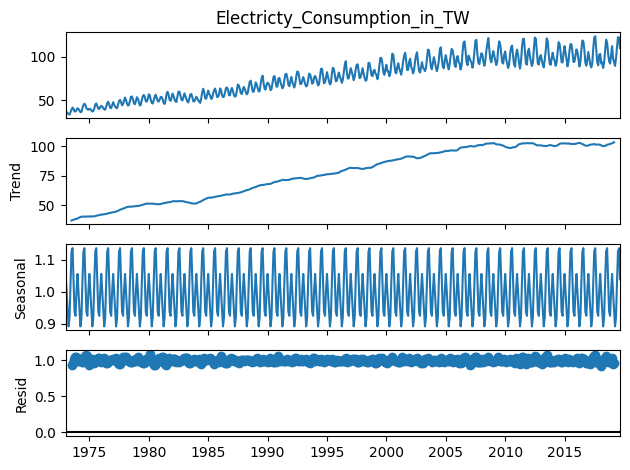

In [11]:

decomposition = seasonal_decompose(time_series, model='multiplicative')
decomposition.plot()

# Separating Seasonal, Trend, and Residual Components
pd.concat([decomposition.observed, decomposition.seasonal, decomposition.trend, decomposition.resid], axis=1).head(12)


### Augmented Dickey-Fuller (ADF) Test

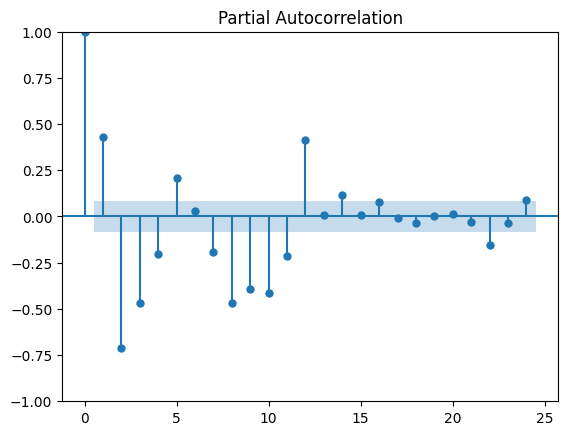

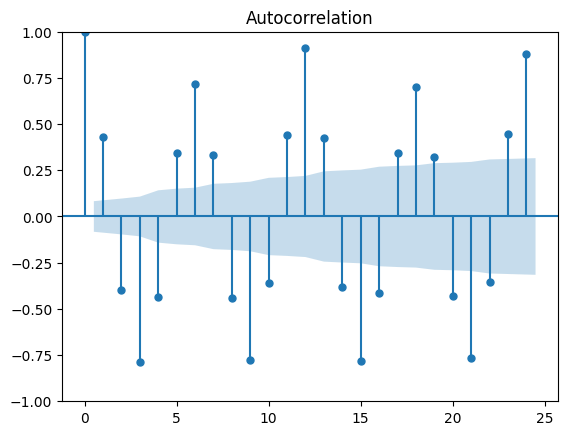

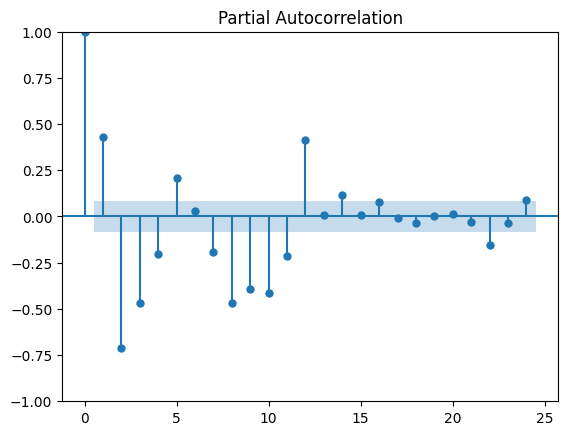

In [13]:
# Checking for Stationarity of Data
adf_result = adfuller(time_series)
log_transformed_series = np.log(time_series)
adf_result_log = adfuller(log_transformed_series)
adf_result_diff = adfuller(time_series.diff(1).dropna())
differenced_series = log_transformed_series.diff(1).dropna()

# ACF Plot
smt.graphics.plot_acf(differenced_series, lags=24)

# PACF Plot
smt.graphics.plot_pacf(differenced_series, lags=24)

### Fitting a model

#### ETS Model

In [14]:
train_data = log_transformed_series[:'2017-09-01']
test_data = log_transformed_series['2017-10-01':]
ets_model = ExponentialSmoothing(train_data, trend='mul', seasonal='mul', seasonal_periods=12).fit(
    smoothing_level=0.1, smoothing_trend=0.2, smoothing_seasonal=0.5)

print(ets_model.summary())

# Forward and Backward Testing
forecast = np.exp(ets_model.forecast(steps=24))
actual = np.exp(test_data)
fitted = np.exp(ets_model.fittedvalues['2016-09-01':])
original = np.exp(train_data['2016-09-01':])

print('MAPE_Train :', np.mean(np.abs((original - fitted) / original)))
print('MAPE_Test :', np.mean(np.abs((actual - forecast) / actual)))

                           ExponentialSmoothing Model Results                           
Dep. Variable:     Electricty_Consumption_in_TW   No. Observations:                  537
Model:                     ExponentialSmoothing   SSE                              0.469
Optimized:                                 True   AIC                          -3749.979
Trend:                           Multiplicative   BIC                          -3681.403
Seasonal:                        Multiplicative   AICC                         -3748.658
Seasonal Periods:                            12   Date:                 Sat, 13 Jan 2024
Box-Cox:                                  False   Time:                         16:34:55
Box-Cox Coeff.:                            None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.100

#### SARIMA Model

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.66830D+00    |proj g|=  1.25608D+01

At iterate    5    f= -2.24710D+00    |proj g|=  1.38362D+01

At iterate   10    f= -2.35793D+00    |proj g|=  3.40652D+00

At iterate   15    f= -2.36105D+00    |proj g|=  2.81268D-01


 This problem is unconstrained.



At iterate   20    f= -2.36317D+00    |proj g|=  1.57535D-01

At iterate   25    f= -2.36328D+00    |proj g|=  4.90316D-01

At iterate   30    f= -2.37702D+00    |proj g|=  7.54883D+00

At iterate   35    f= -2.39304D+00    |proj g|=  1.13771D+00

At iterate   40    f= -2.39880D+00    |proj g|=  1.49785D-01

At iterate   45    f= -2.40038D+00    |proj g|=  9.62737D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     47     66      1     0     0   2.198D-03  -2.400D+00
  F =  -2.4003803813683482     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Result

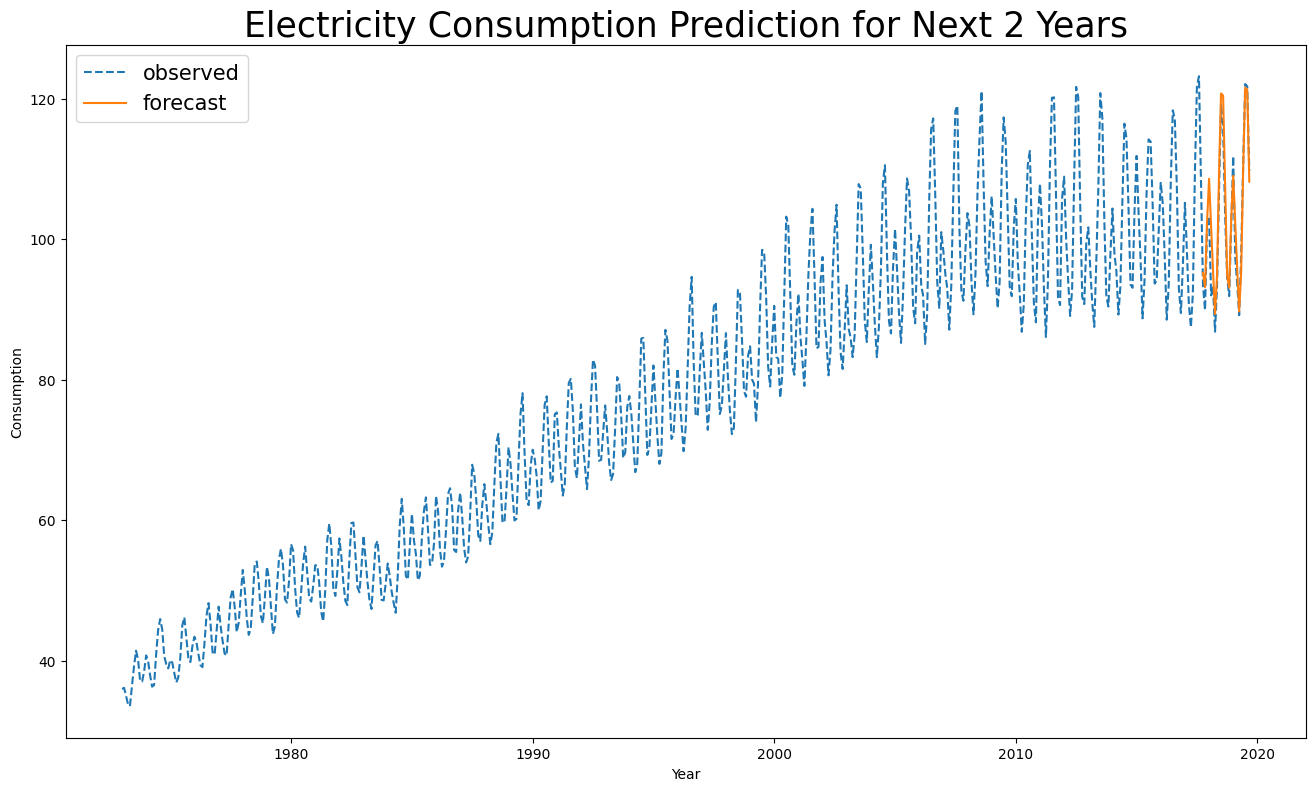

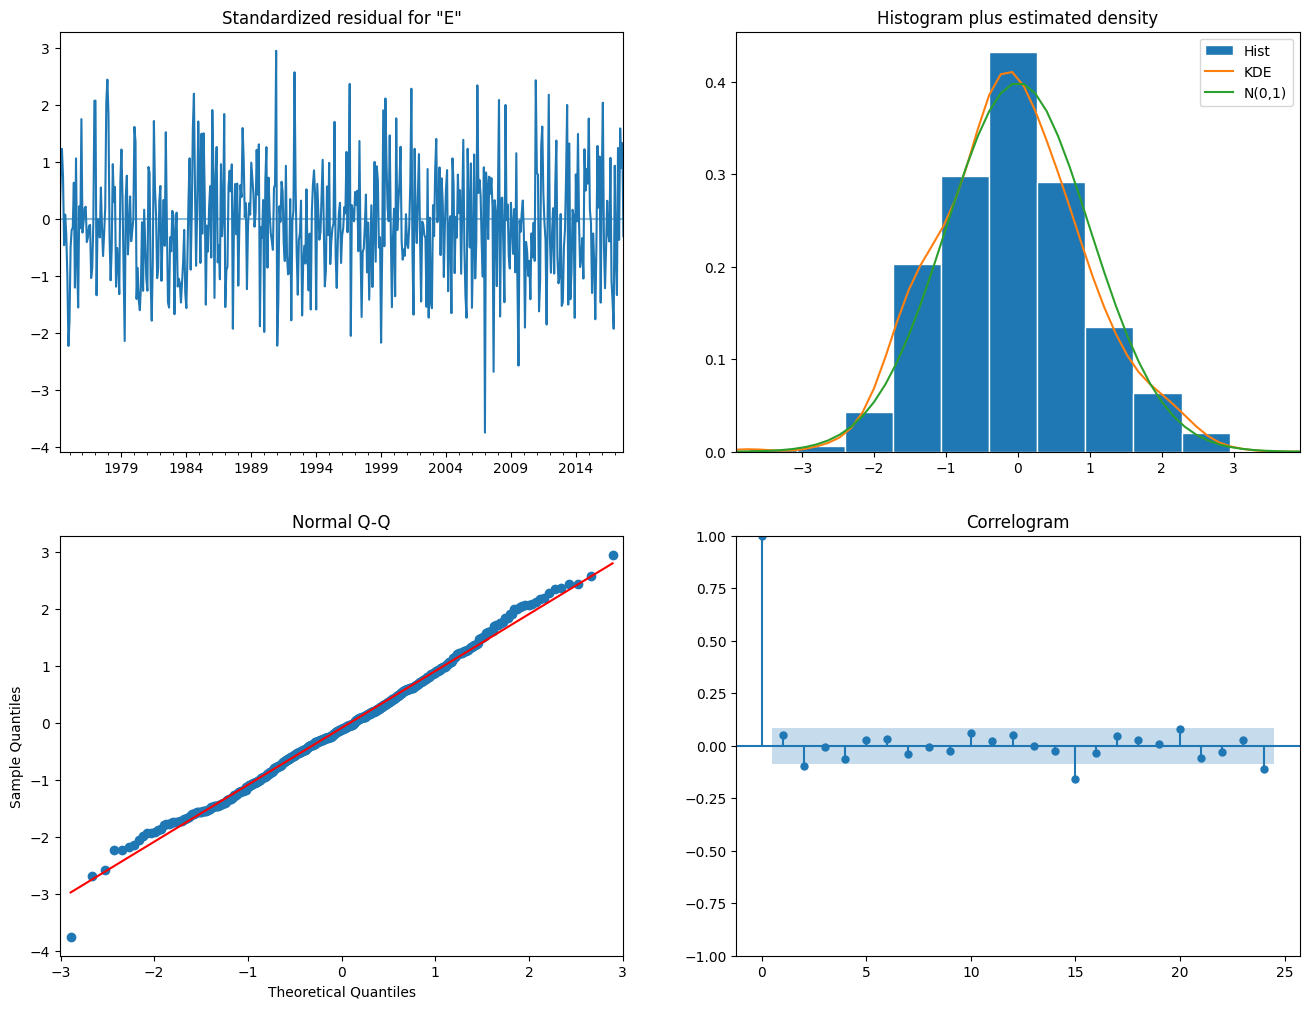

In [15]:
# Determining Best Parameters for the Model (p, d, q)(P, D, Q, T)
p = 1
q = 1
d = 1
P = 1
D = 0
Q = 1
T = 12

sarima_model = smt.SARIMAX(train_data, order=(1,1,1), seasonal_order=(1,0,1,12),
                           enforce_invertibility=False, enforce_stationarity=False).fit()

print(sarima_model.summary())

# Forward and Backward Testing for SARIMA Model
sarima_forecast = np.exp(sarima_model.forecast(steps=24))
sarima_actual = np.exp(test_data)

sarima_fitted = np.exp(sarima_model.fittedvalues['2016-09-01':])
sarima_original = np.exp(train_data['2016-09-01':])

print('MAPE_Train :', np.mean(np.abs((sarima_original - sarima_fitted) / sarima_original)))
print('MAPE_Test :', np.mean(np.abs((sarima_actual - sarima_forecast) / sarima_actual)))

# Plotting Prediction
plt.figure(figsize=(16,9))
plt.plot(time_series, '--', label='observed')
plt.plot(sarima_forecast, '-', label='forecast')
plt.xlabel('Year')
plt.ylabel('Consumption')
plt.legend(fontsize=15)
plt.title('Electricity Consumption Prediction for Next 2 Years', fontsize=25)
plt.show()

# Plotting Diagnostics
sarima_model.plot_diagnostics(lags=24, figsize=(16,12))
plt.show()


### Conclusion

In conclusion, the provided code outlines a comprehensive analysis of electricity consumption data. Beginning with data preparation, the code explores seasonal trends and patterns using exploratory data analysis (EDA) techniques. It employs time series analysis tools such as moving averages, decomposition, and Augmented Dickey-Fuller (ADF) tests to understand and address non-stationarity in the data.

The code evaluates the performance of two forecasting models – Exponential Smoothing (ETS) and Seasonal Autoregressive Integrated Moving Average (SARIMA). Through forward and backward testing, the SARIMA model demonstrates robust predictive accuracy, supported by diagnostics that confirm the model's suitability.

Ultimately, the SARIMA model is deemed the best-fit for predicting electricity consumption demand for the next two years. This comprehensive approach provides valuable insights for effective management and planning in the electricity distribution company.